In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import statsmodels
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/gold/data')

In [0]:
gold = pickle.load(open('gold_price.pkl','rb'))

# ARIMA

### Seasonal Decomposition, STL

<Figure size 2160x2160 with 0 Axes>

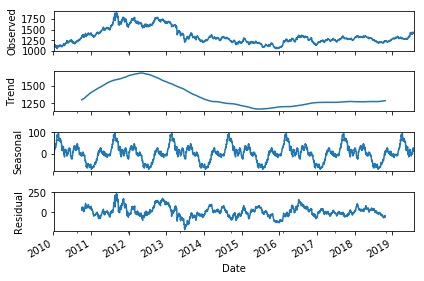

In [0]:
decomposition = seasonal_decompose(gold['USD/T.oz'], freq=365)
fig = plt.figure(figsize=(30, 30))  
fig = decomposition.plot()
plt.show()

In [0]:
# 전체기간
tr_start,tr_end = '2010-01-04','2018-12-28'
te_start,te_end = '2019-01-02','2019-07-31'
tra = gold['USD/T.oz'][tr_start:tr_end].dropna()
tes = gold['USD/T.oz'][te_start:te_end].dropna()

### 정상성 확인 stationarity check, ADF

In [0]:
# Rolling statistics(moving average)
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=365).mean()
    rolstd = pd.Series.rolling(timeseries, window=365).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used',
                                'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

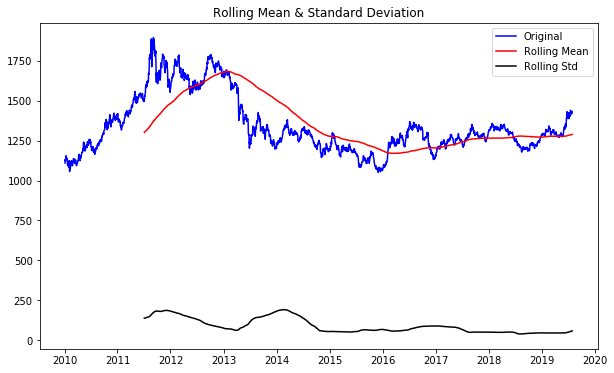

<Results of Dickey-Fuller Test>
Test Statistic                   -2.066885
p-value                           0.258037
#Lags Used                       25.000000
Number of Observations Used    2272.000000
Critical Value (1%)              -3.433231
Critical Value (5%)              -2.862813
Critical Value (10%)             -2.567448
dtype: float64


In [0]:
# 전체기간 정상성 확인
test_stationarity(gold['USD/T.oz'])

### Judgment:  (null-hypothesis: TS is non-stationary)
### p-value < 0.05: reject null-hypothesis –> Stationary
### p-value > 0.05: accept –> non-Stationary

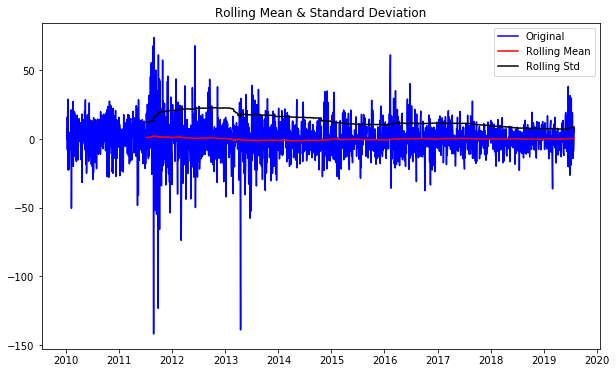

<Results of Dickey-Fuller Test>
Test Statistic                -9.625226e+00
p-value                        1.667581e-16
#Lags Used                     2.700000e+01
Number of Observations Used    2.269000e+03
Critical Value (1%)           -3.433235e+00
Critical Value (5%)           -2.862815e+00
Critical Value (10%)          -2.567449e+00
dtype: float64


In [0]:
# 1차 차분
gold['first_difference'] = gold['USD/T.oz'] - gold['USD/T.oz'].shift(1)  
# Or Alternatively,
# df.diff().plot()
test_stationarity(gold.first_difference.dropna(inplace=False))

### 입력 인수

* x : 시계열 자료
* maxlag : ADF 검정에 사용할 시차의 수. 디폴트 12*(nobs/100)^{1/4}
* regression : 검정 사용할 모형.
* 'nc': 결정론적 추세 없음. DF 검정
* 'c': 상수항만 사용
* 'ct': 상수항과 1차 추세 사용
* 'ctt': 상수항과 1차 추세, 2차 추세 사용
* autolag : 검정 AR 모형의 차수를 자동 결정하는 알고리즘 {‘AIC’, ‘BIC’, ‘t-stat’, None}

### 반환값

* adf : 검정 통계량
* pvalue : MacKinnon(1994) 방식을 사용한 p-value 추정치
* usedlag : 사용된 시차의 수
* nobs : 분석에 자료의 수
* critical values : 1%, 5%, 10% 수준에 해당되는 검정 통계량의 값

In [0]:
# ADF-test(Original-time-series)
res = sm.tsa.adfuller(gold['USD/T.oz'].dropna(),regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.31151477428729685


In [0]:
# ADF-test(differenced-time-series)
res = sm.tsa.adfuller(gold['USD/T.oz'].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:1.667580616115671e-16


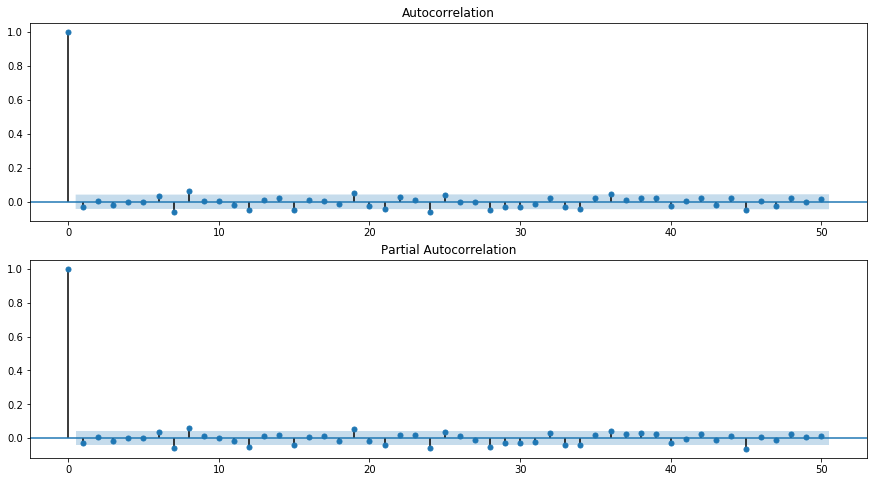

In [0]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(tra.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(tra.diff().dropna(), lags=50, ax=ax[1])
plt.show()

In [0]:
# ar, ma select
# resDiff = sm.tsa.arma_order_select_ic(tra, max_ar=7, max_ma=7, ic='aic', trend='c')
# print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [0]:
# 모델 정의
arima = sm.tsa.SARIMAX(gold['USD/T.oz'], order=(1,1,1),
                       seasonal_order=(0,0,0,0), trend='c',
                       full_output=True, disp=1).fit()
arima.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               USD/T.oz   No. Observations:                 2298
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -9330.713
Date:                Wed, 28 Aug 2019   AIC                          18669.427
Time:                        04:52:26   BIC                          18692.384
Sample:                             0   HQIC                         18677.798
                               - 2298                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2634      0.572      0.461      0.645      -0.857       1.384
ar.L1         -0.8821      0.081    -10.916      0.000      -1.041      -0.724
ma.L1          0.8599      0.086      9.946      0.000       0.690       1.029
sigma2       197.6260      2.308     85.638      0.000     193.103     202.149
===================================================================================
Ljung-Box (Q):                       82.29   Jarque-Bera (JB):             16676.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

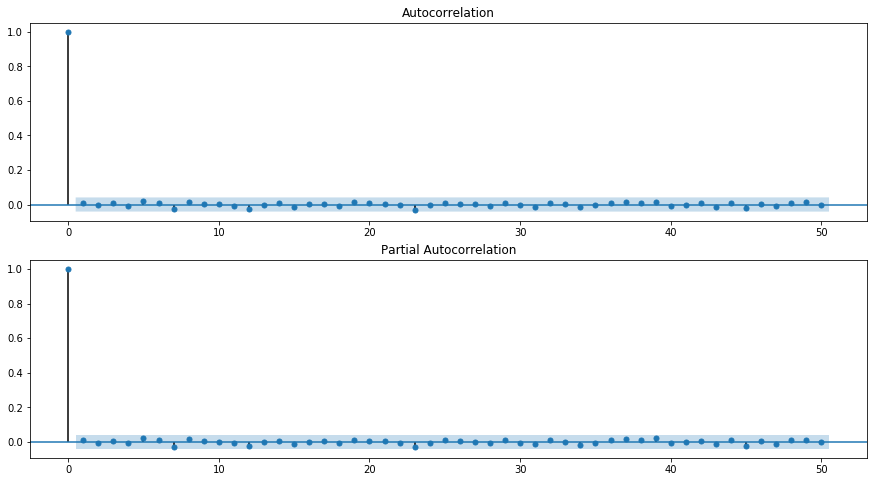

In [0]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [0]:
# 모델 예측
pred = arima.predict(te_start, te_end, dynamic= True)

In [0]:
# r2
r2 = r2_score(tes, pred)
print('r2: {:.3f}'.format(r2))
# rmse
rmse = mean_squared_error(tes, pred)**0.5
print('rmse: {:.3f}'.format(rmse))
# mae
mae = mean_absolute_error(tes, pred)
print('mae: {:.3f}'.format(mae))

r2: -0.392
rmse: 57.675
mae: 39.266


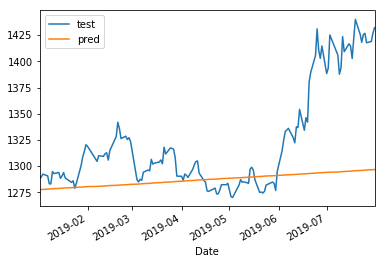

In [0]:
# 그래프 확인
pd.DataFrame({'test':tes,'pred':pred}).plot()
plt.show()

In [0]:
# 예측
fore = arima.forecast(steps=7)
print(fore)

2298    1431.947790
2299    1432.248447
2300    1432.246654
2301    1432.511658
2302    1432.541315
2303    1432.778576
2304    1432.832706
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


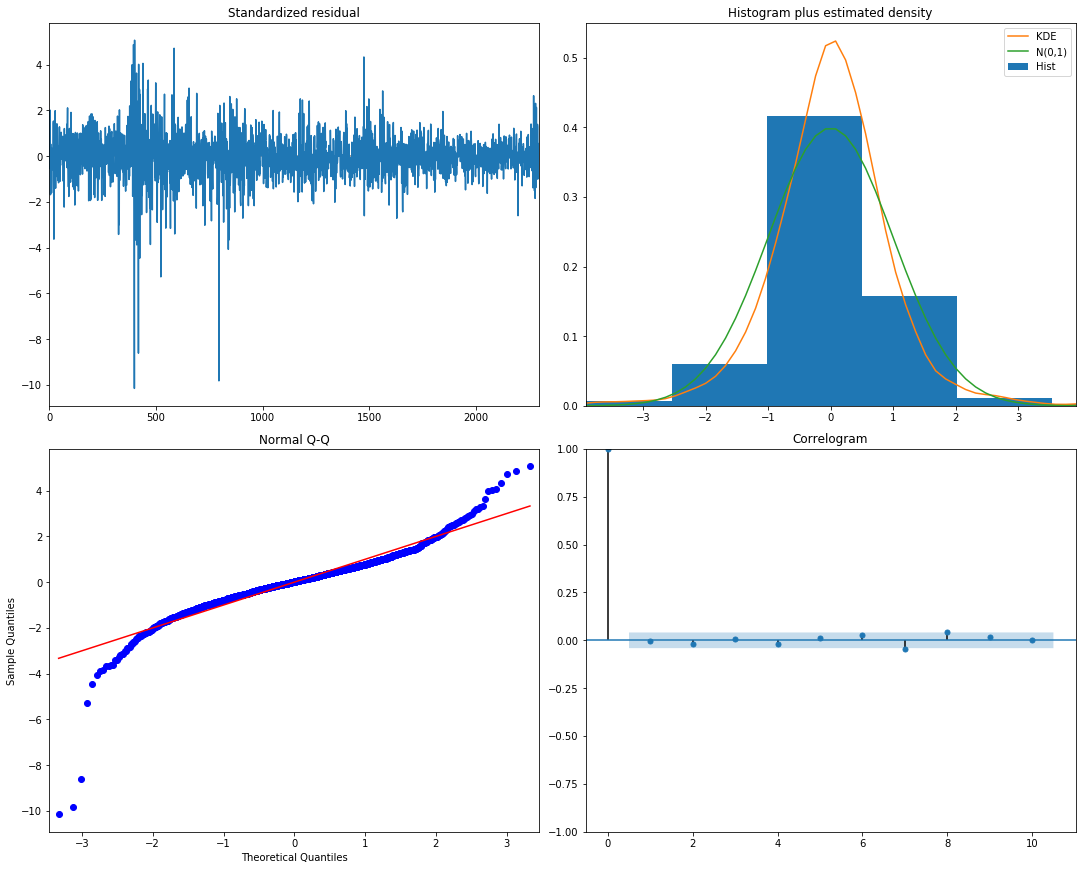

In [0]:
arima.plot_diagnostics(figsize=(15, 12));
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

# ARIMAX (특성추가)

In [0]:
# 데이터 기간 분할
tr_start,tr_end = '2010-01-04','2018-12-28'
te_start,te_end = '2019-01-02','2019-07-31'
tra = gold['USD/T.oz'][tr_start:tr_end].dropna()
tes = gold['USD/T.oz'][te_start:te_end].dropna()

In [0]:
# 추가 특성 추출
exog_train = gold.loc[:, ['index_price', 'cny/krw', 'usd/krw', '100jpy/krw', 'eur/krw', 'gbp/krw','nasdaq', 'kospi', 'dow', 'snp500']][tr_start:tr_end].dropna()
exog_test = gold.loc[:, ['index_price', 'cny/krw', 'usd/krw', '100jpy/krw', 'eur/krw', 'gbp/krw','nasdaq', 'kospi', 'dow', 'snp500']][te_start:te_end].dropna()
exog = gold.loc[:, ['index_price', 'cny/krw', 'usd/krw', '100jpy/krw', 'eur/krw', 'gbp/krw','nasdaq', 'kospi', 'dow', 'snp500']]

In [0]:
# 모델 정의
arimax = sm.tsa.SARIMAX(gold['USD/T.oz'], order=(7,1,6),seasonal_order=(0,0,0,0),
                        exog=exog, enforce_stationarity=False,
                        enforce_invertibility=False).fit()
arimax.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               USD/T.oz   No. Observations:                 2298
Model:               SARIMAX(7, 1, 6)   Log Likelihood               -9105.640
Date:                Wed, 28 Aug 2019   AIC                          18259.279
Time:                        04:54:52   BIC                          18396.951
Sample:                             0   HQIC                         18309.484
                               - 2298                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
index_price     0.1410      0.745      0.189      0.850      -1.320       1.602
cny/krw         0.3298      0.982      0.336      0.737      -1.595       2.254
usd/krw        -1.2966      0.143     -9.038      0.000      -1.578      -1.015
100jpy/krw      0.4345      0.035     12.537      0.000       0.367       0.502
eur/krw         0.2447      0.037      6.592      0.000       0.172       0.317
gbp/krw         0.0843      0.026      3.275      0.001       0.034       0.135
nasdaq         -0.0048      0.019     -0.248      0.804      -0.043       0.033
kospi          -0.0281      0.014     -1.943      0.052      -0.056       0.000
dow            -0.0042      0.010     -0.441      0.659      -0.023       0.015
snp500          0.0318      0.111      0.288      0.773      -0.185       0.249
ar.L1          -0.3796      0.373     -1.017      0.309      -1.111       0.352
ar.L2          -0.2518      0.340     -0.741      0.459      -0.918       0.415
ar.L3          -0.3617      0.229     -1.580      0.114      -0.810       0.087
ar.L4          -0.3775      0.213     -1.776      0.076      -0.794       0.039
ar.L5          -0.3059      0.258     -1.184      0.236      -0.812       0.200
ar.L6          -0.1989      0.231     -0.862      0.389      -0.651       0.253
ar.L7          -0.0636      0.023     -2.710      0.007      -0.110      -0.018
ma.L1           0.3407      0.375      0.909      0.363      -0.394       1.075
ma.L2           0.2288      0.336      0.681      0.496      -0.429       0.887
ma.L3           0.3399      0.228      1.492      0.136      -0.106       0.786
ma.L4           0.3497      0.214      1.632      0.103      -0.070       0.770
ma.L5           0.2373      0.258      0.919      0.358      -0.269       0.743
ma.L6           0.1993      0.220      0.907      0.365      -0.231       0.630
sigma2        166.6007      1.984     83.979      0.000     162.712     170.489
===================================================================================
Ljung-Box (Q):                       69.61   Jarque-Bera (JB):             31217.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

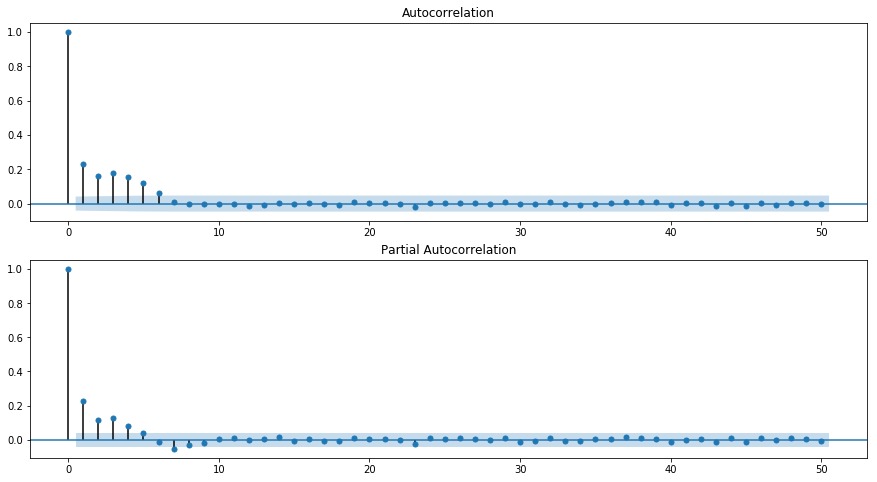

In [0]:
res = arimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [0]:
# 예측
pred = arimax.predict(te_start, te_end, exog = exog, dynamic= True)

In [0]:
# r2
r2 = r2_score(tes, pred)
print('r2: {:.3f}'.format(r2))
# rmse
rmse = mean_squared_error(tes, pred)**0.5
print('rmse: {:.3f}'.format(rmse))
# mae
mae = mean_absolute_error(tes, pred)
print('mae: {:.3f}'.format(mae))

r2: -2.337
rmse: 89.299
mae: 70.881


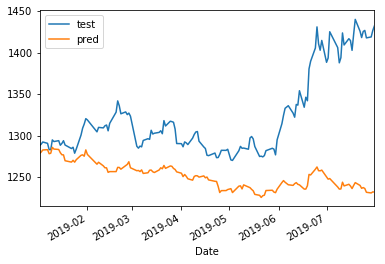

In [0]:
# 그래프
pd.DataFrame({'test':tes,'pred':pred}).plot()
plt.show()

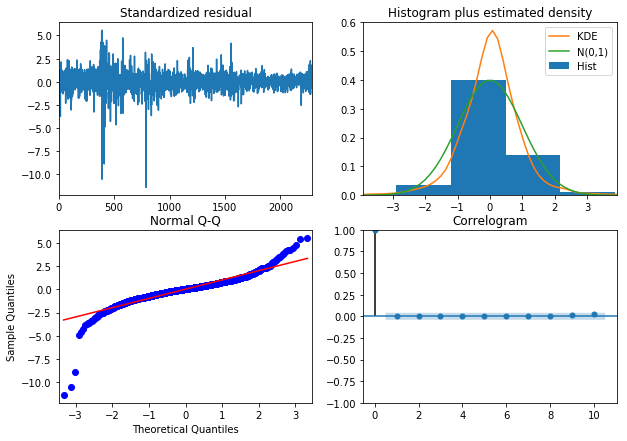

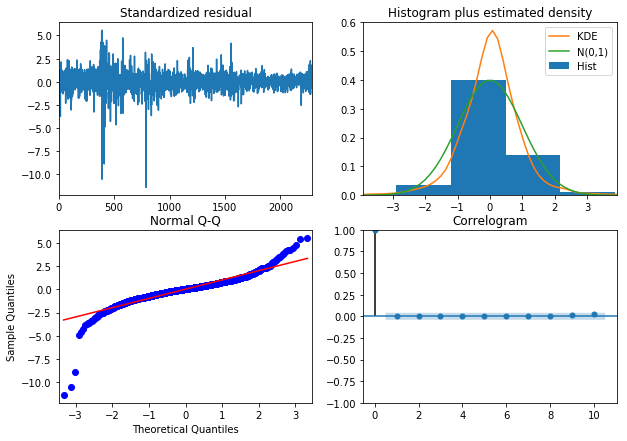

In [0]:
arimax.plot_diagnostics(figsize=(10, 7))

In [0]:
# 예측
fore = arimax.forecast(steps=7, exog=exog.tail(7))
print(fore)

2298    1436.499547
2299    1437.183671
2300    1435.521699
2301    1430.924926
2302    1429.896800
2303    1431.128752
2304    1430.893576
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
